# SSL learning
Learning useful representations through recognising augmentations and matching augmented views

# Part 1: Setup

In [1]:
# imports
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

import utils.ssl_utils as ssl

from tqdm import tqdm
from dataclasses import dataclass, fields
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
from typing import List, Tuple, Optional, Dict, Any
from torch.utils.data import DataLoader, WeightedRandomSampler

## Loading data and exploring augmentations

In [2]:
# Prepare capture24 data and split into train, val and test splits
dm = ssl.Capture24DataManager(srv_root="/srv", local_root="..")
ssl.set_seed(42)
dm.prepare() # checks everything is downloaded
(
    x_tr, y_tr, pid_tr, # x_tr: accel segements, y_tr: labels, pid_tr: participant ID
    x_val, y_val, pid_val, 
    x_te, y_te, pid_te,
    le # label encoder - maps from integer labels to strings
) = dm.train_val_test_split(prop=0.1)

Using existing processed_data/ directory.
Using existing capture24/ directory.


In [3]:
@dataclass
class AugmentConfig:
    jitter: float = 0.5
    scaling: float = 0.5
    time_flip: float = 0.5
    axis_swap: float = 0.2
    time_mask: float = 0.3

class Augmenter:
    """
    Composable time-series augs tailored to wrist accelerometer windows.
    """
    def __init__(self, cfg: AugmentConfig | None = None):
        # if None, fall back to defaults
        self.cfg = cfg or AugmentConfig()

    @classmethod
    def available_ops(cls) -> list[str]:
        """Ops = config fields that have a same-named augmentation method."""
        names = [f.name for f in fields(AugmentConfig)]  # preserves declaration order
        return [n for n in names if hasattr(cls, n) and callable(getattr(cls, n))]

    def probs(self) -> dict[str, float]:
        """Current op -> probability mapping from the config."""
        return {n: getattr(self.cfg, n) for n in self.available_ops()}

    # ---- primitive ops: (C, L) -> (C, L) ----
    @staticmethod
    def jitter(x: torch.Tensor, sigma: float = 0.01) -> torch.Tensor:
        # add small Gaussian noise
        return x + torch.randn_like(x) * sigma

    @staticmethod
    def scaling(x: torch.Tensor, sigma: float = 0.1) -> torch.Tensor:
        # per-sample scalar scale ~ N(1, sigma^2)
        s = torch.randn((), device=x.device) * sigma + 1.0  # shape ()
        return x * s

    @staticmethod
    def time_flip(x: torch.Tensor) -> torch.Tensor:
        # reverse along time axis
        return torch.flip(x, dims=[-1])

    @staticmethod
    def axis_swap(x: torch.Tensor) -> torch.Tensor:
        # swap y and z (requires >=3 channels); no-op otherwise
        if x.size(0) >= 3:
            return x[[0, 2, 1], :]
        return x

    @staticmethod
    def time_mask(x: torch.Tensor, max_frac: float = 0.1) -> torch.Tensor:
        # zero a contiguous span of the series
        L = x.size(-1)
        w = max(1, int(L * max_frac))
        start = random.randint(0, L - w)
        y = x.clone()
        y[:, start:start + w] = 0
        return y

    def view(self, x: torch.Tensor) -> torch.Tensor:
        """
        Stochastic augmentation pipeline.
        """
        if random.random() < self.cfg.jitter:
            x = self.jitter(x)
        if random.random() < self.cfg.scaling:
            x = self.scaling(x)
        if random.random() < self.cfg.axis_swap:
            x = self.axis_swap(x)
        if random.random() < self.cfg.time_mask:
            x = self.time_mask(x)
        if random.random() < self.cfg.time_flip:
            x = self.time_flip(x)
        return x
        

### Visualising augmentations
Below we sample an accelerometer segment. To ensure the segment is interesting, we pick one with a high standard deviation. Your job is to go through each of the augmentations, apply them, and document how each augmentation changes the accelerometer data.

Then, re-examine what happens if you augment a segment with a much lower standard deviation. Is it still easy to detect the difference between the augmented and unaugmented signal?

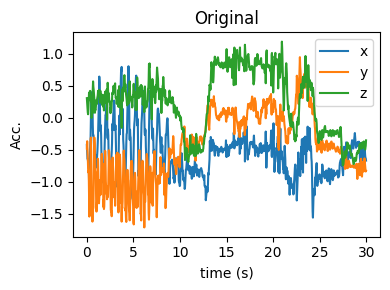

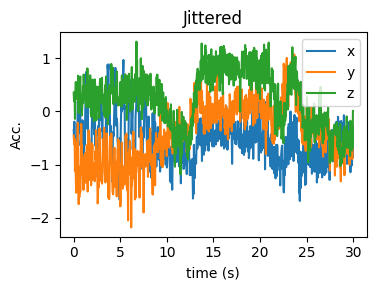

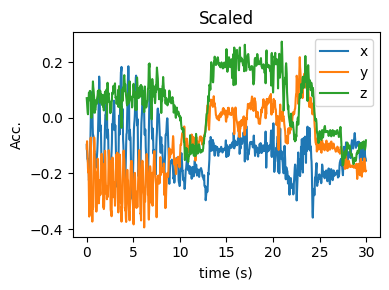

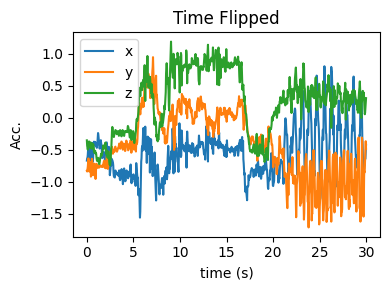

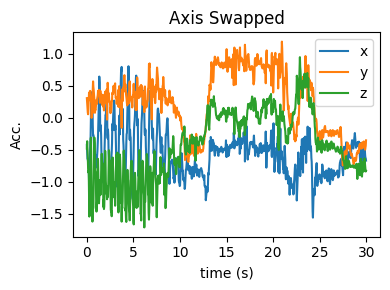

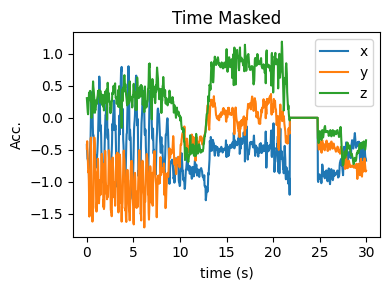

In [4]:
# Compute SD of each segment and pick the 90th percentile example
sds = np.std(x_tr, axis=(1,2)) 
p90 = np.percentile(sds, 90)
argp90 = np.argmin(np.abs(sds - p90))
x_org = x_tr[argp90]

# Visualise the original segment
fig, ax = ssl.visualize_segment(x_org, title="Original")

# Apply augmentations to it to figure out what each is doing
aug = Augmenter()

x_org =  torch.from_numpy(x_org) # Convert segment to tensor

# Jitter 
x_jitter = aug.jitter(x_org, sigma=0.2)
fig, ax = ssl.visualize_segment(x_jitter.numpy(), title="Jittered")

# Scaling 
x_scale = aug.scaling(x_org, sigma=0.5)
fig, ax = ssl.visualize_segment(x_scale.numpy(), title="Scaled")

# Time flip 
x_flip = aug.time_flip(x_org)
fig, ax = ssl.visualize_segment(x_flip.numpy(), title="Time Flipped")

# Axis Swap 
x_swap = aug.axis_swap(x_org)
fig, ax = ssl.visualize_segment(x_swap.numpy(), title="Axis Swapped")

# Time Mask 
x_mask = aug.time_mask(x_org, max_frac=0.1)
fig, ax = ssl.visualize_segment(x_mask.numpy(), title="Time Masked")


# Part 2: Experiment 1 - Augmentation Recognition Pre-training & Fine-tuning
So far, we have split data into training, validation and test splits, and we have explored different ways of augmenting segments of accelerometer data. 
Let's now use these augmentations to implement a SSL method: Augmentation recognition pretraining. In this method, we train a model to recognise when different augmentations have been applied to a data-set.

## 1.1: Pre-training Setup
Preparing data-sets of augmented accelerometers segments.
Goals: 
- Data-set of augmented segments (X), where the applied augmentations are documented (y),
- Introduce configs and keeping track of all the hyperparameters which impact model performance,
- Create a data-loader which samples more-informative samples,
- Check that a batch of data looks reasonable

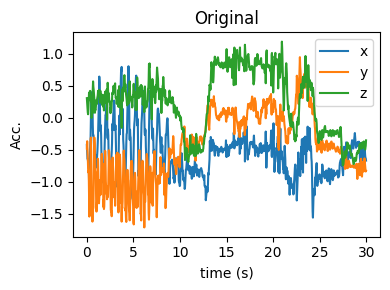

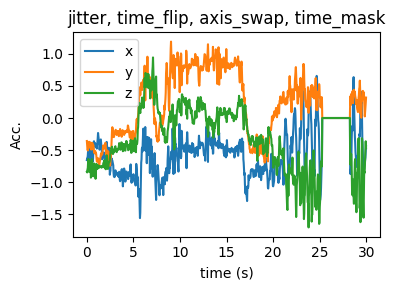

In [5]:
# Prepare the data-set!
 
# Implement the AugRec __getitem__ method.
class AugRecDataset(ssl.BaseWearableDataset):
    def __init__(
        self, 
        X: np.ndarray, 
        augmenter: Augmenter, 
    ):
        super().__init__(X=X, y=None, augmenter=augmenter)
        self.ops = self.aug.available_ops()          # dynamic, ordered
        self._op_probs = self.aug.probs()            # dict for quick lookup

    def __getitem__(self, idx):
        x = self._get_x(idx)                         # (C, L)
        labels = torch.zeros(len(self.ops), dtype=torch.float32)

        # Go through the augementation operations and apply them based on their probabilities
        # TODO: Potential student exercise
        for k, op in enumerate(self.ops):
            p = self._op_probs[op]
            if random.random() < p:
                labels[k] = 1.0
                x = getattr(self.aug, op)(x)         # call op by name

        return x, labels
    
# Define the train data-set, visualise one of the (X,y) pairs
aug_cfg = AugmentConfig() # Make any changes to the augmentation config here
aug = Augmenter(cfg=aug_cfg) 
train_dataset = AugRecDataset(
    X=x_tr,
    augmenter=aug,
)

# Let's visualise one of the data-points before augmentation, and after augmentations
x_org = x_tr[argp90]
fig, ax = ssl.visualize_segment(x_org, title="Original")

x_train, y_train = train_dataset[argp90]
appl_augs = ", ".join([aug.available_ops()[k] for k, b in enumerate(y_train) if b > 0])
fig, ax = ssl.visualize_segment(x_train, title=appl_augs)

In [6]:
# Define a train config to keep track of training hyperparameters
@dataclass
class TrainConfig:
    seed: int = 42
    batch_size: int = 8 # The number of training examples we use to estimate the loss from
    num_workers: int = 2 # The number of workers involved in preparing training examples in parallel
    max_epochs: int = 3
    lr: float = 1e-3
    weight_decay: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

train_cfg = TrainConfig()

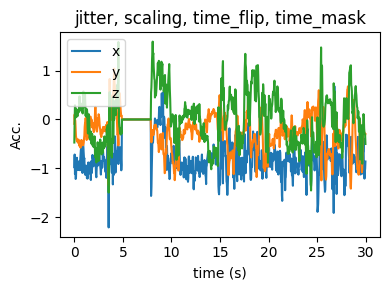

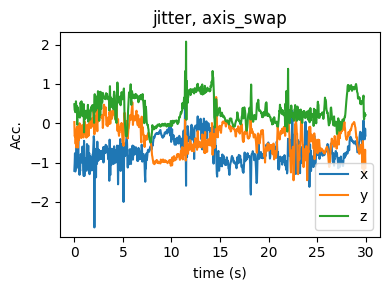

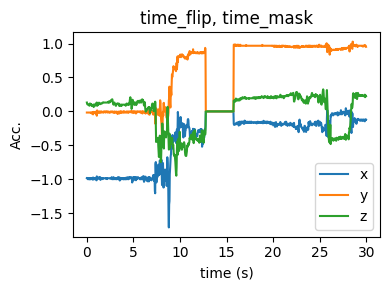

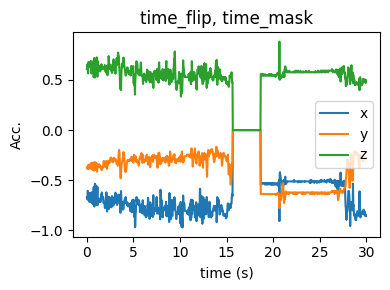

In [7]:
# Prepare data-loaders that efficiently sample and batch the data for model training
# weights from std (as you had)
def make_weights(values: np.ndarray, alpha: float = 1.0) -> torch.Tensor:
    v = values - values.min()
    if v.max() > 0: v = v / v.max()
    v = (v + 1e-6) ** alpha
    return torch.from_numpy(v.astype(np.float32))

# assume x_tr, x_val are (N,C,L) and exist already
sds = np.std(x_tr, axis=(1, 2))
sds = np.nan_to_num(sds, nan=0.0, posinf=0.0, neginf=0.0)
weights = make_weights(sds, alpha=2.0)

sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

aug_train = DataLoader(
    dataset=train_dataset,
    batch_size=train_cfg.batch_size,
    sampler=sampler, # comment out this line to see the impact of sampling!
    shuffle=False,
    num_workers=train_cfg.num_workers,
    pin_memory=True
)

aug_val = DataLoader(
    dataset=AugRecDataset(X=x_val, augmenter=Augmenter(cfg=aug_cfg)),
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

# Visualise samples in one batch - here you can compare the difference including the sampler makes!
check_batch = next(iter(aug_train))

for x_train, y_train in list(zip(*check_batch))[:4]:
    appl_augs = ", ".join([aug.available_ops()[k] for k, b in enumerate(y_train) if b > 0])
    fig, ax = ssl.visualize_segment(x_train, title=appl_augs)

## 1.2 Initialise and Pre-train the Augmentation Recognition Model
- Model is based on OxWearables/ssl-wearables model, and we wrap the backbone of the model in task specific heads
- Again, use config to keep track of hyperparameters

Goals:
- Check that the model can do a forward pass of one batch

In [ ]:
# Build the model! - this is less the focus of the notebook, but look into the ssl_utils.py file if interested in the details
model_cfg = ssl.SSLConfig(
    hub=ssl.HubConfig(pretrained=True),
    model=ssl.ModelConfig(
        in_channels=3,
        input_len=900,
        proj_dim=128,
        num_classes=len(le.classes_),
        k_labels=len(train_dataset.ops),
        freeze_backbone=False),
)

model = ssl.SSLNet(model_cfg)

x_batch, y_batch = check_batch
with torch.inference_mode():
    aug_pred = model(x_batch, head="aug")   # logits (1, k_labels)

print("Input shape:", tuple(x_batch.shape))
print("Model aug_pred shape:", tuple(aug_pred.shape))
print("Ground truth label shape:", tuple(y_batch.shape))

print("\nRaw aug_pred logits:\n", aug_pred[0])
pred_bin = (aug_pred > 0).int()  # naive threshold at 0
print("\nNaive binarized predictions:\n", pred_bin[0])
print("\nGround truth labels:\n", y_batch[0])
# We expect the untrained model predictions to be random

Using cache found in /home/ese575/home/cache/torch/hub/OxWearables_ssl-wearables_main


131 Weights loaded
Input shape: (8, 3, 900)
Model aug_pred shape: (8, 5)
Ground truth label shape: (8, 5)

Raw aug_pred logits:
 tensor([ 0.2149,  0.3943, -0.2285, -0.1030,  0.1636])

Naive binarized predictions:
 tensor([1, 1, 0, 0, 1], dtype=torch.int32)

Ground truth labels:
 tensor([1., 1., 1., 0., 1.])


### Check that we can overfit a batch

[Overfit-check] batch shape: x=(8, 3, 900), y=(8, 5)
 step 020 | loss 0.0045
 step 040 | loss 0.0018
 step 060 | loss 0.0011
 step 080 | loss 0.0009
 step 100 | loss 0.0007
 start loss=0.6989  end loss=0.0007


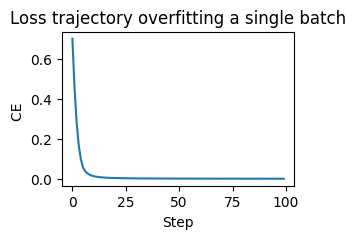

In [9]:
# Check model can overfit to one batch
def overfit_one_batch_augrec(model, dl, steps=100, lr=1e-2, device="cpu"):
    model.train().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    b = next(iter(dl))
    x, y = b[0].to(device), b[1].to(device)

    print(f"[Overfit-check] batch shape: x={tuple(x.shape)}, y={tuple(y.shape)}")
    losses = []
    for t in range(steps):
        # =========== This defines the logic for augmentation 
        logits = model(x, head="aug")
        # TODO: Potential student exercise, implement the loss function 
        loss = F.binary_cross_entropy_with_logits(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
        if (t+1) % max(1, steps//5) == 0:
            print(f" step {t+1:03d} | loss {losses[-1]:.4f}")
    print(f" start loss={losses[0]:.4f}  end loss={losses[-1]:.4f}")
    return losses

losses = overfit_one_batch_augrec(model, aug_train, lr=train_cfg.lr, device=train_cfg.device)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("CE ")
ax.set_title("Loss trajectory overfitting a single batch")
plt.show()

100%|██████████| 539/539 [00:04<00:00, 126.79it/s]


[AugRec] epoch 000  train 0.5687  val 0.7702


100%|██████████| 539/539 [00:04<00:00, 108.44it/s]


[AugRec] epoch 001  train 0.5565  val 0.5131


100%|██████████| 539/539 [00:04<00:00, 110.18it/s]


[AugRec] epoch 002  train 0.5193  val 0.5072


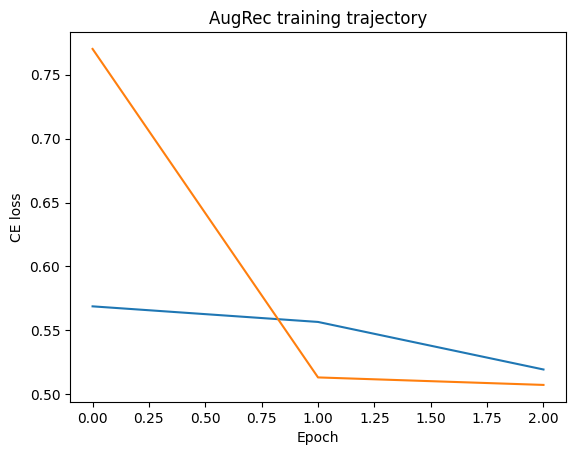

In [10]:
# Do model pretraining
def augrec_pretraining(
    model: nn.Module,
    train_dl: DataLoader,
    val_dl: DataLoader,
    device: str = "cpu",
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    max_epochs: int = 20,
) -> Dict[str, List[float]]:
    """
    Simple augmentation-recognition training loop.

    Args:
        model: nn.Module with an augmentation head (called with head="aug")
        train_dl: DataLoader yielding (x, y) batches for training
        val_dl: DataLoader yielding (x, y) batches for validation
        device: device string ("cpu" or "cuda")
        lr: learning rate
        weight_decay: weight decay for Adam optimizer
        max_epochs: number of epochs to train

    Returns:
        history: dictionary with lists of per-epoch train and val loss
    """
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history: Dict[str, List[float]] = {"train_loss": [], "val_loss": []}

    for epoch in range(max_epochs):
        # ---- training ----
        model.train()
        train_loss_sum, n = 0.0, 0
        for x, y in tqdm(train_dl):
            x, y = x.to(device), y.to(device)
            logits = model(x, head="aug")
            # TODO: Potential student exercise, implement the loss function 
            loss = F.binary_cross_entropy_with_logits(logits, y)
            train_loss_sum += loss.item() * x.size(0)
            n += x.size(0)
            # Zero the gradients, backpropagate, and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
        train_loss = train_loss_sum / max(1, n)

        # ---- validation ----
        model.eval()
        val_loss_sum, n = 0.0, 0
        with torch.inference_mode():
            for x, y in tqdm(val_dl):
                x, y = x.to(device), y.to(device)
                logits = model(x, head="aug")
                # TODO: Potential student exercise, implement the loss function 
                loss = F.binary_cross_entropy_with_logits(logits, y)
                val_loss_sum += loss.item() * x.size(0)
                n += x.size(0)
        val_loss = val_loss_sum / max(1, n)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"[AugRec] epoch {epoch:03d}  train {train_loss:.4f}  val {val_loss:.4f}")

    return history

# Do the actual training!
hist_ar = augrec_pretraining(model, aug_train, aug_val, 
                     device=train_cfg.device,
                     lr=train_cfg.lr, weight_decay=train_cfg.weight_decay,
                     max_epochs=train_cfg.max_epochs)


# Plot train, val loss trajectories
fig, ax = plt.subplots()
ax.plot(hist_ar["train_loss"], label="Train")
ax.plot(hist_ar["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("CE loss")
ax.set_title("AugRec training trajectory")
plt.show()

## 1.3 Fine-tune the AR Model
We have trained a backbone model, now let's do **supervised** fine-tuning using the model to see it's performance for activity recognition

Goals:
- Learn how to freeze different components of the model
- Implement supervised training loop
- Get evaluation metrics on the validation loop

### Freezing parts of a model
In PyTorch, every parameter (nn.Parameter) has a boolean flag `requires_grad`. During the backward pass, autograd only computes gradients for parameters with requires_grad=True. Optimizers (e.g. Adam) only update parameters that have a non-None .grad. So if you set p.requires_grad = False, then:
- No gradient is computed for that parameter.
- Its .grad stays None.
- The optimizer skips updating it.

In [ ]:
# Model component freezing
for p in model.backbone.parameters(): p.requires_grad = False
for p in model.proj.parameters():     p.requires_grad = False
for p in model.aug_head.parameters(): p.requires_grad = False
for p in model.cls_head.parameters(): p.requires_grad = True # just unfreeze a classification head

In [ ]:
def supervised_finetuning(
    model: nn.Module,
    train_dl: DataLoader,
    val_dl: DataLoader,
    device: str = "cpu",
    lr: float = 5e-4,
    weight_decay: float = 1e-4,
    max_epochs: int = 10,
) -> Dict[str, List[float]]:
    """
    Supervised training loop (no freezing here). Tracks loss only.
    Expects model(x, head='cls') -> logits [B, C]; y is Long [B].
    """
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    history: Dict[str, List[float]] = {"train_loss": [], "val_loss": []}
    train_loss_sum, n = 0.0, 0

    for epoch in range(max_epochs):
        # --- train ---
        model.train()
        train_loss_sum, n = 0.0, 0
        for x, y in tqdm(train_dl):
            x, y = x.to(device), y.to(device).long()
            logits = model(x, head="cls")
            loss = ce(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss_sum += loss.item() * x.size(0)
            n += x.size(0)
        train_loss = train_loss_sum / max(1, n)

        # --- validate ---
        model.eval()
        val_loss_sum, n = 0.0, 0
        with torch.inference_mode():
            for x, y in tqdm(val_dl):
                x, y = x.to(device), y.to(device).long()
                logits = model(x, head="cls")
                loss = ce(logits, y)
                val_loss_sum += loss.item() * x.size(0)
                n += x.size(0)
        val_loss = val_loss_sum / max(1, n)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"[Supervised] epoch {epoch:03d}  train {train_loss:.4f}  val {val_loss:.4f}")

    return history

# Do the actual training!
aug_cfg = AugmentConfig(jitter=0.5, scaling=0.5, time_flip=0.0, axis_swap=0.0, time_mask=0.3)
aug = Augmenter(cfg=aug_cfg)

sup_train = DataLoader(
    ssl.BaseWearableDataset(X=x_tr, y=y_tr, augmenter=aug), 
    batch_size=train_cfg.batch_size, shuffle=True, num_workers=train_cfg.num_workers
)
sup_val = DataLoader(
    ssl.BaseWearableDataset(X=x_val, y=y_val, augmenter=None),
    batch_size=train_cfg.batch_size, shuffle=False, num_workers=train_cfg.num_workers
)
sup_test = DataLoader(
    ssl.BaseWearableDataset(X=x_te, y=y_te, augmenter=None),
    batch_size=train_cfg.batch_size, shuffle=False, num_workers=train_cfg.num_workers
)

hist_sf = supervised_finetuning(model, sup_train, sup_val, 
                     device=train_cfg.device,
                     lr=train_cfg.lr, weight_decay=train_cfg.weight_decay,
                     max_epochs=train_cfg.max_epochs)


# Plot train, val loss trajectories
fig, ax = plt.subplots()
ax.plot(hist_sf["train_loss"], label="Train")
ax.plot(hist_sf["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("CE loss")
ax.set_title("Supervised finetuning training trajectory")
plt.show()

## 1.4: Final Test Set Evaluation for the Augmentation Recognition Model
Look at peformance metrics of the fine-tuned model

In [ ]:
def evaluate(
    model: nn.Module,
    dl: DataLoader,
    device: str = "cpu",
    label_names: Optional[List[str]] = None,
) -> Dict[str, Any]:
    """
    Runs inference and returns accuracy, macro/weighted F1, and per-class PRF.
    """
    model.eval().to(device)
    all_true, all_pred = [], []
    ce = nn.CrossEntropyLoss(reduction="sum")
    loss_sum, n = 0.0, 0

    with torch.inference_mode():
        for x, y in dl:
            x, y = x.to(device), y.to(device).long()
            logits = model(x, head="cls")
            loss_sum += ce(logits, y).item()
            n += x.size(0)
            preds = logits.argmax(dim=1)
            all_true.append(y.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    avg_loss = loss_sum / max(1, n)
    y_true = np.concatenate(all_true) if all_true else np.array([], dtype=int)
    y_pred = np.concatenate(all_pred) if all_pred else np.array([], dtype=int)

    if y_true.size == 0:
        return {}

    # infer class count
    num_classes = int(max(y_true.max(), y_pred.max()) + 1)
    print(num_classes)

    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), zero_division=0
    )
    metrics = {
        "loss": avg_loss,
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted", zero_division=0)),
        "per_class": [
            {
                "class": (label_names[k] if label_names is not None and k < len(label_names) else str(k)),
                "precision": float(prec[k]),
                "recall": float(rec[k]),
                "f1": float(f1[k]),
                "support": int(support[k]),
            }
            for k in range(num_classes)
        ],
    }
    # Print summary of performance
    print(f"[Eval] loss {avg_loss:.4f}  F1(macro) {metrics['f1_macro']:.3f}  F1(weighted) {metrics['f1_weighted']:.3f}")
    header = f"{'Class':15s} {'Prec':>8s} {'Rec':>8s} {'F1':>8s} {'Support':>8s}"
    print(header)
    print("-" * len(header))
    for row in metrics["per_class"]:
        print(f"{row['class']:15s} "
            f"{row['precision']:8.3f} "
            f"{row['recall']:8.3f} "
            f"{row['f1']:8.3f} "
            f"{row['support']:8d}") 
    return metrics

ar_metrics = evaluate(model, sup_test, device=train_cfg.device, label_names=le.classes_)

# Part 3: Experiment 2 - Contrastive Learning 
This part of the noteboook notebook implements the **joint-embedding (contrastive)** paradigm of self-supervised learning. The goal is to teach the model to learn that two differently augmented views of the same signal are *similar*, while views from different signals are *dissimilar*.

The core components are:

1. **A** ```ContrastiveDataset```: For each sample, it returns two independently augmented 'views' (```v1```, ```v2```).

2. **A Projection Head**: The model projects the backbone's features into a smaller, normalised space where similarity is measured. 

3. **An NT-Xent Loss Function**: This contrastive loss function encourages the projected views from the same source sample to be close together, while pushing views from different samples far apart.

In [12]:
# TODO: Potential student exercise, think through which of these augmentations make sense for contrastive learning
aug_cfg = AugmentConfig(
    jitter=0.5,
    scaling=0.5,
    time_flip=0.0,
    axis_swap=0.0,
    time_mask=0.3
)
aug = Augmenter(cfg=aug_cfg)

## 2.1: Pre-training Setup
Here, we set up the components needed for the contrastive task.

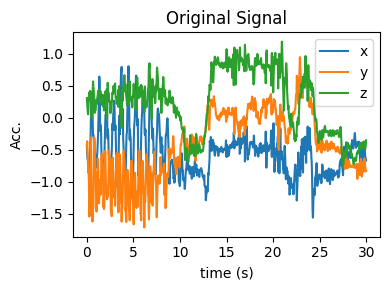

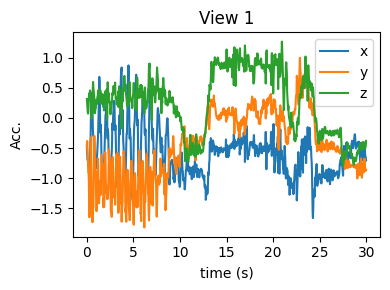

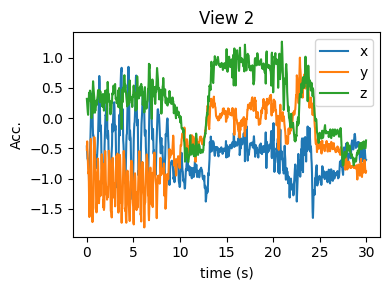

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'View 2'}, xlabel='time (s)', ylabel='Acc.'>)

In [ ]:
# Implement the ContrastiveDataset __getitem__ method.
class ContrastiveDataset(ssl.BaseWearableDataset):
    def __getitem__(self, idx):
        # TODO: Potential student exercise
        x = self._get_x(idx)
        v1 = self.aug.view(x)
        v2 = self.aug.view(x)
        return v1, v2
# Unlike AugRecDataset, it doesn't provide labels (Y) of the augmentations applied, instead it returns two views of the same signal.
train_dataset = ContrastiveDataset(
    X=x_tr,
    augmenter=aug
)

val_dataset = ContrastiveDataset(
    X=x_val, 
    augmenter=aug
)

# Let's take the train set and visualise the two views for one segment
sds = np.std(x_tr, axis=(1,2))
p90 = np.percentile(sds, 90)
argp90 = np.argmin(np.abs(sds-p90))

v1, v2 = train_dataset[argp90]
fig, ax = ssl.visualize_segment(x_tr[argp90], title="Original Signal")
fig, ax = ssl.visualize_segment(v1, title="View 1")
fig, ax = ssl.visualize_segment(v2, title="View 2")
plt.show()

### Define a train config
We add a **temperature (τ)** parameter for the NT-Xent loss. It's a small positive number that scales the similarity scores before they are fed into the loss function. A lower temperature makes the differences between similarities more pronounced, forcing the model to work harder to distinguish between easy and hard negative examples.

It's a key hyperparameter in contrastive learning that helps the model with learning learning better representations effectively.


In [ ]:
@dataclass
class TrainConfig(TrainConfig):
    temperature: float = 0.1

train_cfg = TrainConfig(
    batch_size=8,
    num_workers=2,
    lr=1e-3,
    weight_decay=1e-4,
    max_epochs=3,
    patience=1,
    temperature=0.1
)

In [16]:
# Prepare the dataloaders with our new data-sets
contrastive_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_cfg.batch_size,
    sampler=sampler, # we can reuse the previous weighted sampler
    shuffle=False,
    num_workers=train_cfg.num_workers,
    pin_memory=True
)

contrastive_val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers 
    # No sampler because we want to validate on a representative set, rather than picking biased, high-intensity samples like in training
    # pin_memory not required as validation less compute-intensive
)

## 2.2: Initialise and Pre-train the Contrastive Model

In [ ]:
# TODO 
# Build the model. The SSLNet from ssl_utils is already set up with a projection head.
model_cfg_contrastive = ssl.SSLConfig(
    model=ssl.ModelConfig(
        in_channels=3, # The X,Y,Z accelerometry channels
        proj_dim=128, # Dimension of the space for contrastive loss (projection head output)
        num_classes=4, # For the downstream task (Non-wear, Sedentary, LPA, MVPA)
        freeze_backbone=False # We want to continue training the whole model (not just fine-tuning the head)
    )
)

# Re-initialising model for contrastive learning...
model_contrastive = ssl.SSLNet(model_cfg_contrastive)

# Check the output of the projection head 
v1_batch, v2_batch = next(iter(contrastive_train_loader))
with torch.inference_mode():
    z1 = model_contrastive(v1_batch, head="proj")
    z2 = model_contrastive(v2_batch, head="proj")

print("Input view shape:", tuple(v1_batch.shape))
print("Projected embedding shape (z1): ", tuple(z1.shape))

### Sanity Check: Overfitting a Single Batch

In [ ]:
# A new sanity check function for the contrastive task.
def overfit_one_batch_contrastive(model, dl, steps=100, lr=1e-3, temp=0.1, device="cpu"):
    model.train().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    v1, v2 = next(iter(dl))
    v1, v2 = v1.to(device), v2.to(device)

    print(f"[Overfit-check] batch shape: v1={tuple(v1.shape)}, v2={tuple(v2.shape)}")
    losses = []

    for t in range(steps):
        z1 = model(v1, head="proj")
        z2 = model(v2, head="proj")
        loss = ssl.nt_xent_loss(z1, z2, temperature=temp) 
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
        if (t+1) % max(1, steps//5) == 0:
            print(f" step {t+1:03d} | loss {losses[-1]:.4f}")
    print(f" start loss={losses[0]:.4f}  end loss={losses[-1]:.4f}")
    return losses

_ = overfit_one_batch_contrastive(model_contrastive, contrastive_train_loader, lr=train_cfg.lr, temp=train_cfg.temperature, device=train_cfg.device)

In [ ]:
# Do model pretraining using the contrastive task.
# The Trainer in ssl_utils.py already has a 'fit_contrastive' method.
trainer_contrastive = ssl.Trainer(train_cfg)
hist_contrastive = trainer_contrastive.fit_contrastive(model_contrastive, contrastive_train_loader, contrastive_val_loader)

# Plot train and val loss trajectories
fig, ax = plt.subplots()
ax.plot(hist_contrastive["train_loss"], label="Train")
ax.plot(hist_contrastive["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("NT-Xent Loss")
ax.set_title("Contrastive Pre-Training Trajectory")
ax.legend()
plt.show()

## 2.3: Fine-tune the Contrastive Model
Now that the model's feature extractor has been pre-trained using the contrastive objective, we can assess its performance. Like with the Augmentation Recognition model, we will **freeze the pre-trained backbone** and train only a simple linear classifier on top of it using the labeled data. This tests the quality of the learned features.


In [ ]:
# We can reuse the `sup_train` and `sup_val` DataLoaders from the first experiment.

# The Trainer's finetune method will handle freezing the backbone and training the classifier head.
print("Fine-tuning the contrastive-pretrained model")

finetune_results_con = trainer_contrastive.finetune(
    model=model_contrastive, 
    train_dl=sup_train, 
    val_dl=sup_val, 
    label_names=le.classes_
)

# Plot the fine-tuning loss trajectory
hist_finetune_con = finetune_results_con # The finetune method returns the history
fig, ax = plt.subplots()
ax.plot(hist_finetune_con["train_loss"], label="Train")
ax.plot(hist_finetune_con["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Contrastive Model: Fine-tuning Trajectory")
ax.legend()
plt.show()

## 2.4: Final Test Set Evaluation for the Contrastive Model
After fine-tuning, we perform a final evaluation on the held-out test set to get an unbiased measure of the model's performance on the Human Activity Recognition task.


In [ ]:
# Evaluate the fine-tuned model 
print("Final Evaluation on Test Set")

test_metrics_con = trainer_contrastive.evaluate(
    model=model_contrastive, 
    test_dl=sup_test, 
    label_names=le.classes_
)